In [1]:
import sys
sys.path.append("../../")

from transportnet import net
from transportnet import line
from transportnet import vehicle
from stochastic import stochastic

from genetics import ga
import tools

from matplotlib import pyplot as plt
from scipy import stats as ss
import numpy as np

In [2]:
n = net.Net()

n.load_nodes_from_file('verkhnodniprovsk_nodes.txt')
# define the network configuration
n.load_from_file('verkhnodniprovsk_edges.txt')

# define demand intensity
for nd in n.nodes:
    nd.s_interval = stochastic.Stochastic(law=2, scale=30)
central = n.get_node(code=1)
central.s_interval = stochastic.Stochastic(law=2, scale=5)

# define a set of public transport lines
line1 = line.Line(n, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                    13, 12, 11, 15, 16, 17, 18, 19, 1], 
                    [1, 14])
line1.same_back_direction = False
line1.color = 'red'
line1.add_vehicles([vehicle.Vehicle(18)])

line2 = line.Line(n, [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 18, 31, 32, 16, 10, 1],
                    [1, 1])
line2.same_back_direction = False
line2.color = 'green'
line2.add_vehicles([vehicle.Vehicle(50)])
line3 = line.Line(n, [1, 20, 33, 34, 35, 36, 37, 38,
                    37, 39, 36, 35, 18, 19, 1],
                    [1, 38])
line3.same_back_direction = False
line3.color = 'brown'
line3.add_vehicles([vehicle.Vehicle(18)])
line4 = line.Line(n, [1, 3, 4, 40, 41, 42, 43, 44,
                    43, 42, 41, 40, 4, 3, 1],
                    [1, 44])
line4.same_back_direction = True
line4.color = 'blue'
line4.add_vehicles([vehicle.Vehicle(38)])
line5 = line.Line(n, [1, 3, 4, 40, 41, 42, 45, 46, 47,
                    46, 45, 42, 41, 40, 4, 3, 1],
                    [1, 47])
line5.same_back_direction = True
line5.color = 'grey'
line5.add_vehicles([vehicle.Vehicle(38)])

n.lines.extend([line1, line2, line3, line4, line5])

## Simulate net

In [3]:
sim_time = 2.0 * 60
n.duration = sim_time
model_runs = 300

def fitness_function(shifts):
    res = []
    for _ in range(model_runs):
        n.reset()
        for idx in range(len(n.lines)):
            n.lines[idx].schedule_shift = shifts[idx]
        n.gen_demand(duration=n.duration)
        x = n.simulate(sim_time)
        res.append(x)
    return np.array(res)

# res = fitness_function([75, 90, 30, 95, 0])
# res.mean()

## Run GA

In [ ]:
model_runs = 5

winners = []
for pm in range(1, 11):
    ws = []
    for tm in range(1, 11):
        print(pm, tm)
        g = ga.GA()
        g.chromosome_size = len(n.lines), 7
        g.population_size = 100
        g.generations = 10
        g.crossover_probability = 0.5
        g.mutation_probability = 0.05 * pm
        g.mutation_turns = tm
        g.fitness_function = lambda xs: fitness_function(xs).mean()
        winner = g.run()
        ws.append(winner[1])
        print()
    winners.append(ws)
    print()

1 1
winner #1 ([25, 15, 13, 24, 49], (42.9144886808159, <genetics.chromosome.Chromosome object at 0x16b3108e0>))
winner #2 ([43, 60, 15, 23, 2], (42.470002922158116, <genetics.chromosome.Chromosome object at 0x13004d330>))
winner #3 ([17, 15, 13, 24, 49], (40.99633401940986, <genetics.chromosome.Chromosome object at 0x16b0d3160>))
winner #4 ([25, 15, 13, 24, 50], (40.30491848545292, <genetics.chromosome.Chromosome object at 0x13004d300>))
winner #5 ([7, 31, 13, 24, 49], (40.73810027341166, <genetics.chromosome.Chromosome object at 0x13004ff10>))
winner #6 ([7, 31, 13, 24, 49], (40.475308183352965, <genetics.chromosome.Chromosome object at 0x16af0c9a0>))
winner #7 ([17, 15, 13, 24, 49], (40.81422488332938, <genetics.chromosome.Chromosome object at 0x13003ab30>))
winner #8 ([7, 31, 13, 24, 49], (40.027643367243584, <genetics.chromosome.Chromosome object at 0x16b0d23b0>))
winner #9 ([7, 31, 13, 24, 48], (40.63920764468365, <genetics.chromosome.Chromosome object at 0x13004ed10>))
winner #1

In [4]:
np.array(winners).tofile('net_pm_pn_10x10x10.txt', sep=',', format='%s')

NameError: name 'winners' is not defined

## Analyze results

In [3]:
xs = np.fromfile('net_results/net_pm_pn_10x10x10.txt', sep=',').reshape((10, 10, 10))
linear = lambda a, b, c, x1, x2: a + b * x1 + c * x2
alpha = 0.05

In [4]:
tticks = np.array([x for x in range(1, 11, 1)])
pticks = np.array([0.05 * x for x in range(1, 11, 1)])
X = np.array([np.array([[x] * 10 for x in pticks]).flatten(), [x for x in tticks] * 10]).T
rm_min = tools.make_regression(X, xs.min(axis=2).flatten(), alpha=alpha, verbose=True)[0]
rm_max = tools.make_regression(X, xs.max(axis=2).flatten(), alpha=alpha, verbose=True)[0]
rm_mean = tools.make_regression(X, xs.mean(axis=2).flatten(), alpha=alpha, verbose=True)[0]

intercept=38.998398636179154
coefs=[0.75308867 0.02962571]
R2=0.09228071015307726
t_alfa(0.05,97)=1.984723185927883
coef1	True	0.29987733604260847	1.2062999954764657
coef2	True	0.006965145837630034	0.052286278809322885
intercept=42.63660796455858
coefs=[-0.22215194 -0.02255903]
R2=0.011612226229763323
t_alfa(0.05,97)=1.984723185927883
coef1	False	-0.9218355882548748	0.4775317141829731
coef2	False	-0.057543215581649154	0.012425149540243232
intercept=40.42411517331923
coefs=[0.36788408 0.00886308]
R2=0.0372339181218565
t_alfa(0.05,97)=1.984723185927883
coef1	True	0.05473904548331909	0.6810291138224037
coef2	False	-0.006794172562654261	0.024520330854299974


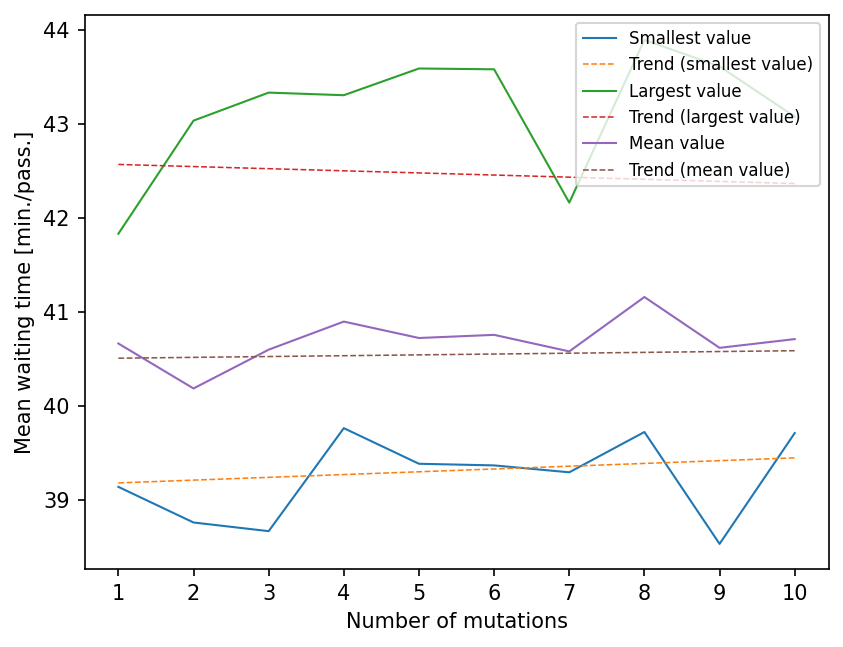

In [10]:
i = 3

plt.figure(dpi=150)

# plt.plot(tticks, xs[i].min(axis=1), lw=1.0, label='Мінімальне значення', linestyle='-')
# plt.plot(tticks, linear(rm_min.intercept_, rm_min.coef_[0], rm_min.coef_[1], pticks[i], tticks),
#          lw=0.75, label='Тренд (мінімальне значення)', linestyle='--')

# plt.plot(tticks, xs[i].max(axis=1), lw=1.0, label='Максимальне значення', linestyle='-')
# plt.plot(tticks, linear(rm_max.intercept_, rm_max.coef_[0], rm_max.coef_[1], pticks[i], tticks),
#          lw=0.75, label='Тренд (максимальне значення)', linestyle='--')

# plt.plot(tticks, xs[i].mean(axis=1), lw=1.0, label='Середнє значення', linestyle='-')
# plt.plot(tticks, linear(rm_mean.intercept_, rm_mean.coef_[0], rm_mean.coef_[1], pticks[i], tticks),
#          lw=0.75, label='Тренд (середнє значення)', linestyle='--')

# plt.ylabel('Середній час очікування [хв./.пас.]')
# plt.xlabel('Кількість мутацій')

plt.plot(tticks, xs[i].min(axis=1), lw=1.0, label='Smallest value', linestyle='-')
plt.plot(tticks, linear(rm_min.intercept_, rm_min.coef_[0], rm_min.coef_[1], pticks[i], tticks),
         lw=0.75, label='Trend (smallest value)', linestyle='--')

plt.plot(tticks, xs[i].max(axis=1), lw=1.0, label='Largest value', linestyle='-')
plt.plot(tticks, linear(rm_max.intercept_, rm_max.coef_[0], rm_max.coef_[1], pticks[i], tticks),
         lw=0.75, label='Trend (largest value)', linestyle='--')

plt.plot(tticks, xs[i].mean(axis=1), lw=1.0, label='Mean value', linestyle='-')
plt.plot(tticks, linear(rm_mean.intercept_, rm_mean.coef_[0], rm_mean.coef_[1], pticks[i], tticks),
         lw=0.75, label='Trend (mean value)', linestyle='--')

plt.ylabel('Mean waiting time [min./pass.]')
plt.xlabel('Number of mutations')

plt.xticks(tticks)
plt.legend(fontsize=8, loc='upper right')

plt.show()

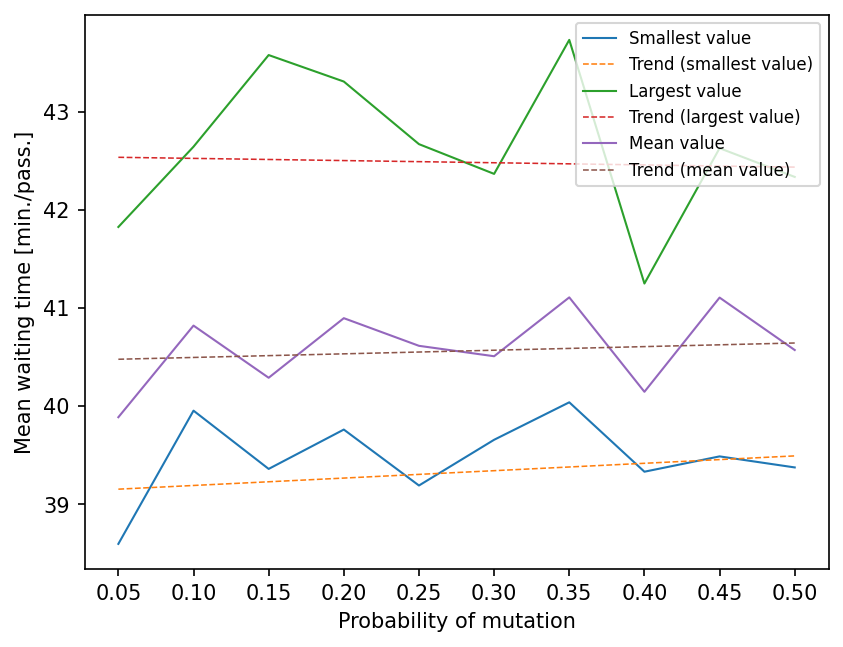

In [11]:
j = 3

plt.figure(dpi=150)

# plt.plot(pticks, xs[:, j].min(axis=1), lw=1.0, label='Мінімальне значення', linestyle='-')
# plt.plot(pticks, linear(rm_min.intercept_, rm_min.coef_[0], rm_min.coef_[1], pticks, tticks[j]),
#          lw=0.75, label='Тренд (мінімальне значення)', linestyle='--')

# plt.plot(pticks, xs[:, j].max(axis=1), lw=1.0, label='Максимальне значення', linestyle='-')
# plt.plot(pticks, linear(rm_max.intercept_, rm_max.coef_[0], rm_max.coef_[1], pticks, tticks[j]),
#          lw=0.75, label='Тренд (максимальне значення)', linestyle='--')

# plt.plot(pticks, xs[:, j].mean(axis=1), lw=1.0, label='Середнє значення', linestyle='-')
# plt.plot(pticks, linear(rm_mean.intercept_, rm_mean.coef_[0], rm_mean.coef_[1], pticks, tticks[j]),
#          lw=0.75, label='Тренд (середнє значення)', linestyle='--')

# plt.ylabel('Середній час очікування [хв./.пас.]')
# plt.xlabel('Імовірність мутації')

plt.plot(pticks, xs[:, j].min(axis=1), lw=1.0, label='Smallest value', linestyle='-')
plt.plot(pticks, linear(rm_min.intercept_, rm_min.coef_[0], rm_min.coef_[1], pticks, tticks[j]),
         lw=0.75, label='Trend (smallest value)', linestyle='--')

plt.plot(pticks, xs[:, j].max(axis=1), lw=1.0, label='Largest value', linestyle='-')
plt.plot(pticks, linear(rm_max.intercept_, rm_max.coef_[0], rm_max.coef_[1], pticks, tticks[j]),
         lw=0.75, label='Trend (largest value)', linestyle='--')

plt.plot(pticks, xs[:, j].mean(axis=1), lw=1.0, label='Mean value', linestyle='-')
plt.plot(pticks, linear(rm_mean.intercept_, rm_mean.coef_[0], rm_mean.coef_[1], pticks, tticks[j]),
         lw=0.75, label='Trend (mean value)', linestyle='--')

plt.ylabel('Mean waiting time [min./pass.]')
plt.xlabel('Probability of mutation')

plt.xticks(pticks)
plt.legend(fontsize=8, loc='upper right')

plt.show()